In [1]:
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

np.random.seed(42)


def density_matrix(state):
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = [label_0, label_1]

In [49]:
X_tra = []
Y_ans = []
with open('genomes.txt', 'r') as f:
    x = f.readlines()
x = x[1:]
for i in range(len(x)):
    x[i] = x[i][:-1]
    x[i] = x[i].split(',')
    X_tra.append(x[i][:-1])
    Y_ans.append(x[i][-1:])
x
ans = []
for i in range(len(Y_ans)):
    if(Y_ans[i]==min(Y_ans)):
        Y_ans[i]=['0']
    ans.append(Y_ans[i][0])
for i in range(len(X_tra)):
    ans[i]=int(ans[i])
    for j in range(len(X_tra[i])):
        X_tra[i][j]=float(X_tra[i][j])
X_tra

[[4.06, 71.01, 57.2, 5.82],
 [3.63, 65.62, 52.68, 5.44],
 [3.63, 68.9, 58.29, 6.06],
 [4.11, 75.59, 62.81, 6.44],
 [4.0, 70.86, 58.05, 6.06],
 [3.41, 56.58, 52.68, 5.48],
 [3.15, 62.38, 58.02, 6.11],
 [3.36, 54.78, 53.54, 5.72],
 [3.08, 53.88, 42.26, 4.64],
 [3.49, 58.8, 46.78, 5.02],
 [3.7, 65.66, 51.85, 5.44],
 [4.13, 71.02, 56.37, 5.82],
 [3.73, 70.03, 57.46, 6.06],
 [4.17, 75.72, 61.98, 6.44],
 [4.05, 70.57, 57.23, 6.06],
 [4.48, 75.8, 61.74, 6.44],
 [4.31, 80.07, 61.51, 7.35],
 [3.9, 75.05, 56.99, 6.97],
 [4.19, 80.41, 67.59, 6.97],
 [4.21, 83.36, 69.05, 6.95],
 [4.59, 88.17, 73.56, 7.33],
 [4.26, 96.54, 80.34, 10.02],
 [4.88, 93.76, 83.3, 8.73],
 [4.81, 81.72, 65.69, 6.53],
 [5.18, 86.3, 71.07, 7.15],
 [4.77, 82.47, 70.83, 7.98],
 [4.36, 77.08, 66.31, 7.59],
 [4.81, 86.77, 71.3, 7.04],
 [4.73, 80.23, 70.27, 7.37],
 [3.93, 63.38, 54.62, 5.47],
 [3.99, 66.02, 54.62, 5.47],
 [3.58, 60.72, 50.1, 5.09],
 [3.86, 63.09, 54.68, 5.72],
 [3.99, 66.02, 54.62, 5.47],
 [3.98, 65.41, 54.68, 5.

In [50]:
print(scaler.fit(X_tra))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [51]:
X_tra = scaler.transform(X_tra)

Simple classifier with data reloading and fidelity loss
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [52]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x=None, y=None):
    for i in range(len(params)):
        qml.Rot(x[0]*(math.pi)/2,x[1]*(math.pi)/2,x[2]*(math.pi)/2, wires=0)
        qml.Rot(x[3]*(math.pi)/2,x[4]*(math.pi)/2,0,wires=0)
        qml.Rot(params[i][0]*(math.pi)/2,params[i][1]*(math.pi)/2,params[i][1]*(math.pi)/2, wires=0)
       # qml.Rot(params[i][3]*(math.pi)/2,params[i][4]*(math.pi)/2,params[i][5]*(math.pi)/2, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def fidelity(state1, state2):
    return np.abs(np.dot(np.conj(state1), state2))


def cost(params, x, y, state_labels=None):
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x=x[i], y=dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

Utility functions for testing and creating batches
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [53]:
def test(params, x, y, state_labels=None):
    fidelity_values = []
    output_states = []
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        expectation = qcircuit(params, x=x[i], y=dm_labels[y[i]])
        output_states.append(dev._state)
    predicted = predicted_labels(output_states, state_labels)
    return predicted, output_states


def predicted_labels(states, state_labels=None):
    output_labels = [
        np.argmax([fidelity(s, label) for label in state_labels]) for s in states
    ]
    return np.array(output_labels)


def accuracy_score(y_true, y_pred):
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [54]:
Xdata, Xtest, y_train, y_test = train_test_split(X_tra, ans, test_size=0.33, random_state=42)
Xdata = np.array(Xdata)
Xtest = np.array(Xtest)

Train a quantum classifier on the circle dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [55]:
# Generate training and test data
num_training = 200
num_test = 2000

#Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1))))

#Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1))))


# Train using Adam optimizer and evaluate the classifier
num_layers = 4
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3))
print(params)
predicted_train, states_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, states_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test))

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params = opt.step(lambda v: cost(v, Xbatch, ybatch, state_labels), params)

    predicted_train, states_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, states_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res))

[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]
 [0.70807258 0.02058449 0.96990985]]
Epoch:  0 | Cost: 0.320634 | Train accuracy: 0.512465 | Test Accuracy: 0.547486
Epoch:  1 | Loss: 0.197003 | Train accuracy: 0.681440 | Test accuracy: 0.709497
Epoch:  2 | Loss: 0.159356 | Train accuracy: 0.836565 | Test accuracy: 0.782123
Epoch:  3 | Loss: 0.154752 | Train accuracy: 0.811634 | Test accuracy: 0.754190
Epoch:  4 | Loss: 0.161276 | Train accuracy: 0.808864 | Test accuracy: 0.776536
Epoch:  5 | Loss: 0.168197 | Train accuracy: 0.825485 | Test accuracy: 0.759777
Epoch:  6 | Loss: 0.148238 | Train accuracy: 0.817175 | Test accuracy: 0.765363
Epoch:  7 | Loss: 0.149564 | Train accuracy: 0.831025 | Test accuracy: 0.782123
Epoch:  8 | Loss: 0.141764 | Train accuracy: 0.814404 | Test accuracy: 0.770950
Epoch:  9 | Loss: 0.143303 | Train accuracy: 0.825485 | Test accuracy: 0.787709
Epoch: 10 | Loss: 0.144022 | Train accuracy: 0.828255 |

Results
~~~~~~~



Learned weights
Layer 0: [0.60625391 2.70819449 0.27094646]
Layer 1: [ 0.05919733 -1.38081396 -0.11313261]
Layer 2: [-0.58651612  0.86602124  0.60111502]


NameError: name 'plot_data' is not defined

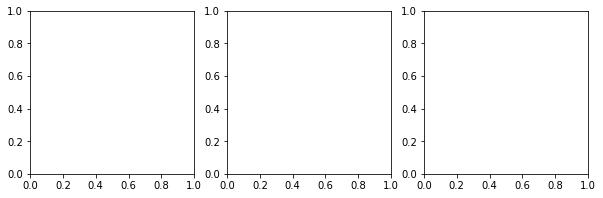

In [37]:
#print("Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
 #       loss, accuracy_train, accuracy_test))

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.show()

This tutorial was generated using the following Pennylane version:



In [ ]:
qml.about()

References
----------
[1] Pérez-Salinas, Adrián, et al. “Data re-uploading for a universal
quantum classifier.” arXiv preprint arXiv:1907.02085 (2019).

[2] Kingma, Diederik P., and Ba, J. "Adam: A method for stochastic
optimization." arXiv preprint arXiv:1412.6980 (2014).

[3] Liu, Dong C., and Nocedal, J. "On the limited memory BFGS
method for large scale optimization." Mathematical programming
45.1-3 (1989): 503-528.

